<a href="https://colab.research.google.com/github/KyoungmiKwon/Bigdata_Training_at_ITwill/blob/main/Team_Project/C05_SJ_add_resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Konlpy 설치
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy


Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/gra

bash: line 6: fg: no job control
bash: line 8: fg: no job control
bash: line 13: !git: command not found
bash: line 14: !pip: command not found
from: can't read /var/mail/ekonlpy.tag
bash: line 17: import: command not found
bash: line 18: import: command not found
bash: line 19: import: command not found


In [ ]:
#Mecab 설치
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.
Processing /tmp/mecab-python-0.996
  Created wheel for mecab-python: filename=mecab_python-0.996_ko_0.9.2-cp37-cp37m-linux_x86_64.whl size=141810 sha256=32cd4d0e1ea0c4da912ada1421b166e005a17c06e16bc92fcc412d4d42b35453
  Stored in directory: /root/.cache/pip/wheels/99/75/a6/e9e73a1dbd73579383644942ef18a6d17ad728a3052a1147fb
Successfully built mecab-python
  Found existing installation: mecab-python 0.996-ko-0.9.2
    Uninstalling mecab-python-0.996-ko-0.9.2:
      Successfully uninstalled mecab-python-0.996-ko-0.9.2


In [ ]:
!git clone https://github.com/entelecheia/eKoNLpy.git
!pip install /content/eKoNLpy

Cloning into 'eKoNLpy'...
remote: Enumerating objects: 3590, done.
remote: Total 3590 (delta 0), reused 0 (delta 0), pack-reused 3590
Receiving objects: 100% (3590/3590), 73.30 MiB | 21.41 MiB/s, done.
Resolving deltas: 100% (2618/2618), done.
Processing ./eKoNLpy
  Created wheel for eKoNLPy: filename=eKoNLPy-0.5.30-cp37-none-any.whl size=14437140 sha256=00d7de6bf075e7a4f0a1f2aa7d3363dcc1a16d3749f13db134c345ed65dca5d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-x8qho81f/wheels/42/07/b6/a197e00efdc4534f4c1d281bd028c47764df1a63a8b311aa3d
Successfully built eKoNLPy


In [ ]:

from ekonlpy.tag import Mecab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import abc
from ekonlpy.utils import installpath

LEXICON_PATH = '%s/data/lexicon' % installpath


class BaseDict(object):
 

    __metaclass__ = abc.ABCMeta

    TAG_POL = 'Polarity'
    TAG_SUB = 'Subjectivity'
    TAG_POS = 'Positive'
    TAG_NEG = 'Negative'

    EPSILON = 1e-6

    def __init__(self, tokenizer=None, kind=None, intensity_cutoff=None):
        self._posdict = {}
        self._negdict = {}
        self._poldict = {}
        self._intensity_cutoff = intensity_cutoff
        self.init_dict(kind, intensity_cutoff)
        if tokenizer is None:
            self.init_tokenizer(kind)
        else:
            self._tokenizer = tokenizer

        assert len(self._posdict) > 0 and len(self._negdict) > 0

    def tokenize(self, text):

        return self._tokenizer.tokenize(text)


    @abc.abstractmethod
    def init_tokenizer(self, kind):
        pass

    @abc.abstractmethod
    def init_dict(self, kind, intensity_cutoff):
        pass

    def _get_score(self, term, by_count=True):

        if by_count:
            if term in self._posdict.keys():
                return self._posdict[term]
            elif term in self._negdict.keys():
                return self._negdict[term]
            else:
                return 0
        else:
            if term in self._poldict.keys():
                return self._poldict[term]
            else:
                return 0

    def get_score(self, terms, by_count=True):

        assert isinstance(terms, list) or isinstance(terms, tuple)
        score_li = [self._get_score(t, by_count) for t in terms]
        pos_score_li = [s for s in score_li if s > 0]
        neg_score_li = [s for s in score_li if s < 0]

        s_pos = sum(pos_score_li)
        s_neg = sum(neg_score_li)

        s_pol = (s_pos + s_neg) * 1.0 / (((s_pos - s_neg) if by_count else len(score_li)) + self.EPSILON)
        s_sub = (len(pos_score_li) + len(neg_score_li)) * 1.0 / (len(score_li) + self.EPSILON)

        return {self.TAG_POS: s_pos,
                self.TAG_NEG: s_neg,
                self.TAG_POL: s_pol,
                self.TAG_SUB: s_sub}

In [ ]:
import abc
import re
import nltk
import os
from ekonlpy.tag import Mecab
from ekonlpy.sentiment.base import LEXICON_PATH
from konlpy.tag import Kkma


class BaseTokenizer(object):
    '''
    An abstract class for tokenize text.
    '''

    __metaclass__ = abc.ABCMeta

    @abc.abstractmethod
    def tokenize(self, text):
        '''Return tokenized temrs.
        
        :type text: str
        
        :returns: list 
        '''
        pass

    # @abc.abstractmethod
    # def ngramize(self, tokens):
    #     '''Return n-gramized temrs.
    #
    #     :type tokens: list of tokens
    #
    #     :returns: list
    #     '''
    #     pass


class KTokenizer(BaseTokenizer):
    '''
    The default tokenizer for KSA sub class.
    The output of the tokenizer is tagged by Kkma.
    '''

    def __init__(self, vocab=None):
        self._tagger = Kkma()
        self._vocab = vocab
        self._min_ngram = 1
        self._ngram = 3
        self._delimiter = ';'
        self._skiptags = ['SF', 'SP', 'SS', 'SE', 'SO', 'SW', 'UN', 'UV', 'UE', 'OL', 'OH', 'ON']

    def tokenize(self, text):
        tokens = []
        if type(text) == list:
            for t in text:
                tokens += self.morpheme(t)
        elif type(text) == str:
            tokens = self.morpheme(text)
        else:
            raise ValueError('The dataset has to be string or list of string type.')

        return self.ngramize(tokens)

    def ngramize(self, tokens):
        ngram_tokens = []
        tokens = [w for w in tokens if w.split('/')[1] not in self._skiptags]
        for pos in range(len(tokens)):
            for gram in range(1, self._ngram + 1):
                token = self.get_ngram(tokens, pos, gram)
                if token:
                    if self._vocab is None:
                        ngram_tokens.append(token)
                    else:
                        if token in self._vocab:
                            ngram_tokens.append(token)
        return ngram_tokens

    def get_ngram(self, tokens, pos, gram):
        if pos < 0:
            return None
        if pos + gram > len(tokens):
            return None
        token = tokens[pos]
        for i in range(1, gram):
            token += self._delimiter + tokens[pos + i]
        return token

    def morpheme(self, dataset):
        return self.align_morpheme(self._tagger.pos(dataset))

    def align_morpheme(self, morpheme):
        return ['{}/{}'.format(w, t) for w, t in morpheme]

In [ ]:
import os
from konlpy.tag import Kkma
from ekonlpy.sentiment.base import LEXICON_PATH, BaseDict
from ekonlpy.sentiment.utils import KTokenizer
from ekonlpy.tag import Mecab

class KSAA(BaseDict):
    '''
    Dictionary class for
    Korean Sentiment Analysis.
    '''

    def init_tokenizer(self, kind=None):
        self._tokenizer = KTokenizer(self._poldict)

    def init_dict(self, kind=None, intensity_cutoff=None):
        path = os.path.join('/content/polar_dictionary.csv')
        with open(path, encoding='utf-8') as f:
            for line in f:
                word = line.split(',')
                w = word[0]
                if w == 'ngram':
                    continue
                
                p = float(word[6].strip())
                n = float(word[3].strip())
                s = p - n
                if len(w) > 1:
                    if s > 0:
                        self._posdict[w] = 1
                        self._poldict[w] = s
                    elif s < 0:
                        self._negdict[w] = -1
                        self._poldict[w] = s


class KOSAC(object):
    def __init__(self):
        self._loaddic()
        self._tagger = Mecab()
        self._ngram = 3
        self._delimiter = ';'
        self._skiptags = ['SF', 'SP', 'SS', 'SE', 'SO', 'SW', 'UN', 'UV', 'UE', 'OL', 'OH', 'ON']

    def _loaddic(self):
        self._polarity = self._loadfile('/content/polar_dictionary.csv')
        self._expressive = self._loadfile(os.path.join(LEXICON_PATH, 'kosac', 'expressive-type.csv'))
        self._intensity = self._loadfile(os.path.join(LEXICON_PATH, 'kosac', 'intensity.csv'))

    def _loadfile(self, file_path, delimiter=','):
        vocab = {}
        if os.path.isfile(file_path):
            with open(file_path) as f:
                for lno, line in enumerate(f):
                    # skip header
                    if lno == 0:
                        headers = line.strip().split(delimiter)
                    else:
                        if len(line) > 0:
                            row = line.strip().split(delimiter)
                            ngram = row[0]
                            # ngram_split = tuple(ngram.split(';'))
                            data = {}
                            for i, header in enumerate(headers):
                                if i > 0:
                                    data[header] = row[i]
                            vocab[ngram] = data
        return vocab

    def morpheme(self, dataset):
        return self.align_morpheme(self._tagger.pos(dataset))

    def align_morpheme(self, morpheme):
        return ['{}/{}'.format(w, t) for w, t in morpheme]

    def percentage(self, obj):
        return {k: v / sum(obj.values()) for k, v in obj.items()}

    def calc(self, keypairs, source, target, func):
        for keypair in keypairs:
            sourcekey = keypair[0]
            targetkey = keypair[1]
            if sourcekey in source:
                sourcedata = source[sourcekey]
                sourcedata = float(sourcedata)
                target[targetkey] = func(sourcedata, target[targetkey])
        return target

    def match(self, data, pairdata, keypairs):
        ret = {k[1]: 0 for k in keypairs}
        for m in data:
            if m in pairdata:
                currentdata = pairdata[m]
                ret = self.calc(keypairs, currentdata, ret,
                                lambda s, t: t + s)
        return self.percentage(ret)

    def polarity(self, data):
        return self.match(data,
                          self._polarity,
                          [['COMP', 'com'],
                           ['POS', 'pos'],
                           ['NEG', 'neg'],
                           ['NEUT', 'neut'],
                           ['None', 'none']])

    def intensity(self, data):
        return self.match(data,
                          self._intensity,
                          [['High', 'high'],
                           ['Low', 'low'],
                           ['Medium', 'medium'],
                           ['None', 'none']])

    def expressive(self, data):
        return self.match(data,
                          self._expressive,
                          [['dir-action', 'dir-action'],
                           ['dir-explicit', 'dir-explicit'],
                           ['dir-speech', 'dir-speech'],
                           ['indirect', 'indirect'],
                           ['writing-device', 'writing-device']])

    def analyze(self, dataset):
        dataset = self.parse(dataset)
        ret = {}
        for analysis in ['polarity', 'intensity', 'expressive']:
            func = getattr(self, analysis)
            ret[analysis] = func(dataset)
        return ret

    def parse(self, dataset):
        tokens = []
        if type(dataset) == list:
            for t in dataset:
                tokens += self.morpheme(t)
        elif type(dataset) == str:
            tokens = self.morpheme(dataset)
        else:
            raise ValueError('The dataset has to be string or list of string type.')

        return self.ngramize(tokens)

    def ngramize(self, tokens):
        ngram_tokens = []
        tokens = [w for w in tokens if w.split('/')[1] not in self._skiptags]
        for pos in range(len(tokens)):
            for gram in range(1, self._ngram + 1):
                token = self.get_ngram(tokens, pos, gram)
                if token:
                    ngram_tokens.append(token)
        return ngram_tokens

    def get_ngram(self, tokens, pos, gram):
        if pos < 0:
            return None
        if pos + gram > len(tokens):
            return None
        token = tokens[pos]
        for i in range(1, gram):
            token += self._delimiter + tokens[pos + i]
        return token

In [ ]:
ksaa = KSAA()

# **resized 사전 사용 >>추가된 사전으로 정확도 측정**

In [ ]:
xls_path='/content/C01_KM_Data_Labeling_resized (1).xlsx'
news_copy = pd.read_excel(xls_path, header=5)

ksaa = KSAA()
title_pol_copy=[]
for i in range(590):
    for k in news_copy['Title'][i].replace('...','').replace('..','').replace('.','').split(sep='.'):
        tokens= ksaa.tokenize(k)
        score = ksaa.get_score(tokens)
        title_pol_copy.append(score['Polarity'])

#제목 극성 /2 = title_polr
title_polr_copy=np.array(title_pol_copy)/2
print(len(title_polr_copy))

text_pol_copy=[]
for i in range(590):
    polar=0
    for k in news_copy['Text'][i].split(sep='.'):
        tokens= ksaa.tokenize(k)
        score = ksaa.get_score(tokens)
        polar+=score['Polarity']
        sen_num=len(news_copy['Text'][i].split(sep='.'))
    text_pol_copy.append(polar/sen_num)

text_polr_copy=np.array(text_pol_copy)/2
total_polr_copy=title_polr_copy + text_polr_copy
news_arr_copy=np.array(news_copy['Sentiment'])
news_copy['title_polar_copy']=title_polr_copy
news_copy['text_polar_copy']=text_polr_copy
news_copy['total_polar_copy']=total_polr_copy

590


In [ ]:
def polar_mean_copy( polar_set):
    aa=news_copy[news_copy['Sentiment']==-1][f'{polar_set}']
    aaa=0
    # bb=news_set[news_set['Sentiment']==0][f'{polar_set}']
    # bbb=0
    cc=news_copy[news_copy['Sentiment']==1][f'{polar_set}']
    ccc=0
    for a in aa:
        aaa+=a

    # for b in bb:
    #     bbb+=b

    for c in cc:
        ccc+=c
    print(aaa/sum(news_copy['Sentiment']==-1), ccc/sum(news_copy['Sentiment']==1))
    print(sum(news_copy['Sentiment']==-1),sum(news_copy['Sentiment']==1))
    # print(f'neg_mean : {aaa/sum(news_set['Sentiment']==-1)}, neut_mean : {bbb/sum(news_set['Sentiment']==0)},pos_mean : {aaa/sum(news_set['Sentiment']==1)}')


In [ ]:
polar_mean_copy('title_polar_copy')
polar_mean_copy('text_polar_copy')
polar_mean_copy('total_polar_copy')

-0.022077302319230108 0.18888206444052785
178 412
0.05396961771751358 0.1291568312498757
178 412
0.031892315398283445 0.31803889569040333
178 412


In [ ]:
accuaracy=[]
for x in np.arange(-0.2,0.2,0.001):
    result_a_copy=[]
    for a in news_copy['total_polar_copy']:    
        if a > x:
            result_a_copy.append(1)
        else:
            result_a_copy.append(-1)
    ac = np.sum(np.equal(news_copy['Sentiment'],result_a_copy))/len(result_a_copy)
    accuaracy.append(ac)
    

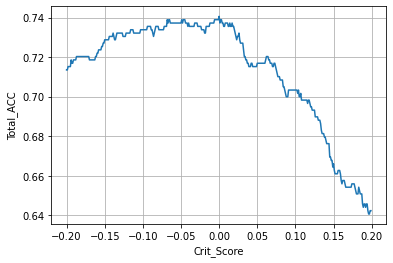

In [ ]:
x= np.arange(-0.2,0.2,0.001)
y=accuaracy
plt.plot(x,y)
plt.xlabel('Crit_Score')
plt.ylabel('Total_ACC')
plt.grid()
plt.show()

# **위와 동일 조건에서 한글자 단어 제거, 한 단어 문장 제거 79~80%**

In [ ]:
xls_path='/content/C01_KM_Data_Labeling_resized (1).xlsx'
news_copy = pd.read_excel(xls_path, header=5)

ksaa = KSAA()
title_pol_co=[]
for i in range(590):
    for k in news_copy['Title'][i].replace('...','').replace('..','').replace('.','').split(sep='.'):
        tokens= ksaa.tokenize(k)
        token_lst=[]  
        for a in tokens:
            one_dot=a.split('/')
            if len(one_dot[0])!=int(1):
                join_dot='/'.join(one_dot)
                token_lst.append(join_dot)
        if len(token_lst) < int(2):
            token_lst=[]
        score = ksaa.get_score(token_lst)
        title_pol_co.append(score['Polarity'])

#제목 극성 /2 = title_polr
title_polr_co=np.array(title_pol_co)/2
print(len(title_polr_co))

text_pol_co=[]
for i in range(590):
    polar=0
    for k in news_copy['Text'][i].split(sep='.'):
        tokens= ksaa.tokenize(k)
        token_lst=[]  
        for a in tokens:
            one_dot=a.split('/')
            if len(one_dot[0])!=int(1):
                join_dot='/'.join(one_dot)
                token_lst.append(join_dot)
        if len(token_lst) < int(2):
            token_lst=[]
        score = ksaa.get_score(token_lst)
        polar+=score['Polarity']
        sen_num=len(news_copy['Text'][i].split(sep='.'))
    text_pol_co.append(polar/sen_num)


text_polr_co=np.array(text_pol_co)*/2
total_polr_co=title_polr_co + text_polr_co
news_arr_co=np.array(news_copy['Sentiment'])
news_copy['title_polar_co']=title_polr_co
news_copy['text_polar_co']=text_polr_co
news_copy['total_polar_co']=total_polr_co




590


In [ ]:
def polar_mean_co( news_column):
    aa=news_copy[news_copy['Sentiment']==-1][f'{polar_set}']
    aaa=0
    # bb=news_set[news_set['Sentiment']==0][f'{polar_set}']
    # bbb=0
    cc=news_copy[news_copy['Sentiment']==1][f'{polar_set}']
    ccc=0
    for a in aa:
        aaa+=a

    # for b in bb:
    #     bbb+=b

    for c in cc:
        ccc+=c
    print(aaa/sum(news_copy['Sentiment']==-1), ccc/sum(news_copy['Sentiment']==1))
    print(sum(news_copy['Sentiment']==-1),sum(news_copy['Sentiment']==1))

In [ ]:
def polar_mean( news_copy,test_col ,target_col):
    aa=news_copy[news_copy[f'{test_col}']==-1][f'{target_col}']
    aaa=0
    # bb=news_set[news_set['Sentiment']==0][f'{polar_set}']
    # bbb=0
    cc=news_copy[news_copy[f'{test_col}']==1][f'{target_col}']
    ccc=0
    for a in aa:
        aaa+=a

    # for b in bb:
    #     bbb+=b

    for c in cc:
        ccc+=c
    print(aaa/sum(news_copy[f'{test_col}']==-1), ccc/sum(news_copy[f'{test_col}']==1))
    print(sum(news_copy[f'{test_col}']==-1),sum(news_copy[f'{test_col}']==1))

In [ ]:
polar_mean_co('title_polar_co')
polar_mean_co('text_polar_co')
polar_mean_co('total_polar_co')

0.004775278796817547 0.16955032952016186
178 412
0.07525937582875146 0.18119911713779613
178 412
0.080034654625569 0.3507494466579579
178 412


In [ ]:
acc=[]
for x in np.arange(-0.2,0.2,0.001):
    result_a_co=[]
    for a in news_copy['total_polar_co']:    
        if a > x:
            result_a_co.append(1)
        else:
            result_a_co.append(-1)
    ac = np.sum(np.equal(news_copy['Sentiment'],result_a_co))/len(result_a_co)
    acc.append(ac)
    


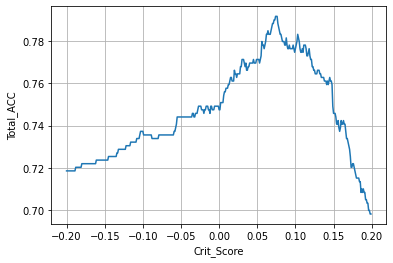

In [ ]:
x= np.arange(-0.2,0.2,0.001)
y=acc
plt.plot(x,y)
plt.xlabel('Crit_Score')
plt.ylabel('Total_ACC')
plt.grid()
plt.show()

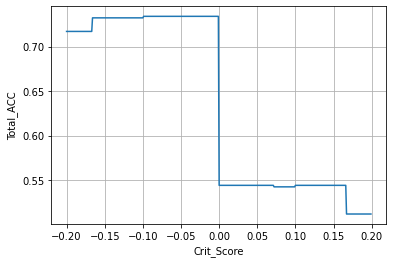

In [ ]:
acc=[]
for x in np.arange(-0.2,0.2,0.001):
    result_a_co=[]
    for a in news_copy['title_polar_co']:    
        if a > x:
            result_a_co.append(1)
        else:
            result_a_co.append(-1)
    ac = np.sum(np.equal(news_copy['Sentiment'],result_a_co))/len(result_a_co)
    acc.append(ac)
x= np.arange(-0.2,0.2,0.001)
y=acc
plt.plot(x,y)
plt.xlabel('Crit_Score')
plt.ylabel('Total_ACC')
plt.grid()
plt.show()

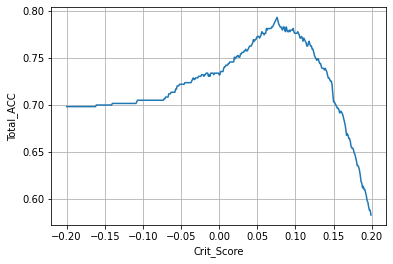

In [ ]:
acc=[]
for x in np.arange(-0.2,0.2,0.001):
    result_a_co=[]
    for a in news_copy['text_polar_co']:    
        if a > x:
            result_a_co.append(1)
        else:
            result_a_co.append(-1)
    ac = np.sum(np.equal(news_copy['Sentiment'],result_a_co))/len(result_a_co)
    acc.append(ac)
x= np.arange(-0.2,0.2,0.001)
y=acc
plt.plot(x,y)
plt.xlabel('Crit_Score')
plt.ylabel('Total_ACC')
plt.grid()
plt.show()

# **text_polar와 title_polar의 가중치 조절을 통한 예측 80~81%**

In [ ]:
title_polr_co_ree=np.array(title_pol_co)*0.2
text_polr_co_ree=np.array(text_pol_co)*0.8
total_polr_co_ree=title_polr_co_ree + text_polr_co_ree
news_copy['total_polar_co_ree']=total_polr_co_ree

In [ ]:
polar_mean_co('total_polar_co_ree')

0.12232511284472937 0.3577387192285384
178 412


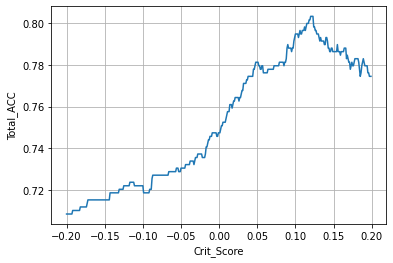

In [ ]:
acc=[]
for x in np.arange(-0.2,0.2,0.001):
    result_a_co_ree=[]
    for a in news_copy['total_polar_co_ree']:    
        if a > x:
            result_a_co_ree.append(1)
        else:
            result_a_co_ree.append(-1)
    ac = np.sum(np.equal(news_copy['Sentiment'],result_a_co_ree))/len(result_a_co_ree)
    acc.append(ac)

x= np.arange(-0.2,0.2,0.001)
y=acc
plt.plot(x,y)
plt.xlabel('Crit_Score')
plt.ylabel('Total_ACC')
plt.grid()
plt.show()

## 기사 수가 적은 날은 중립으로 보고 제외 시킨 뒤 , 
# **나머지 기사를 가지고 감정분석을 통해 긍정, 부정 나누기.** 

In [ ]:
news_resize = pd.read_excel('/content/C01-1_KM_Data_LabelingResult_incl_resize.xlsx')

In [ ]:
news_resize[:10]

,No,Code,Date,Journal,Title,Text,URL,Sample Y/N,In Charge,S
0,3,5930,2021.04.14 17:53,아시아경제,"백악관 회의 참석한 삼성전자, ""대화 자리 만든 바이든에 감사"" 트윗",삼성전자 북미총괄 대외협력 트위터 캡쳐[아시아경제 정현진 기자] 삼성전자를 비롯해 ...,https://finance.naver.com/item/news_read.nhn?a...,Y,KS,1
1,5,5930,2021.04.14 15:38,파이낸셜뉴스,잘나가는 삼성·LG 실적에 '전기전자株' 화색,"[파이낸셜뉴스] 국내 상장기업의 1·4분기 실적시즌이 시작된 가운데 삼성전자, LG...",https://finance.naver.com/item/news_read.nhn?a...,A,JY,1
2,8,5930,2021.04.14 11:25,헤럴드경제,"삼성전자, 美 환경청 주관 ‘기업공로 대상’ 등 수상",삼성전자가 13일(현지시간) 미국 환경청(EPA)이 주관하는 2021년 에너지스타상...,https://finance.naver.com/item/news_read.nhn?a...,Y,KM,1
3,12,5930,2021.04.14 08:09,이데일리,"삼성전자, 美 '에너지스타상' 최고상 영예",미국 환경청 주관... 지속가능 최우수상 올해까지 총 8회 수상[이데일리 배진솔 기...,https://finance.naver.com/item/news_read.nhn?a...,A,JY,1
4,14,5930,2021.04.14 17:40,한국경제,"삼성 '13조 상속세'…연부연납 활용, 올해 낼 2兆 중 1.2兆 대출...",삼성 '13조 상속세' 이재용 부회장 등 재원 마련은…보유주식 담보대출 50~70...,https://finance.naver.com/item/news_read.nhn?a...,A,JY,0
5,15,5930,2021.04.14 16:49,이데일리,"삼성, 車반도체 생산 가능성은…""수익성·기존 고객사 문제로 어려워""","인텔, 美반도체 회의 직후 ""車반도체 생산""MCU 생산 전망…""삼성, 뛰어들기 어려...",https://finance.naver.com/item/news_read.nhn?a...,Y,SW,-1
6,16,5930,2021.04.14 06:30,매일경제,"'돈' 안되는 車 반도체…삼성전자, 美 압박에 고민 깊어지나","인텔 ""차 반도체 6∼9개월 내 생산"" 즉답 삼성 수익성 없어 차량용 거의 안 만...",https://finance.naver.com/item/news_read.nhn?a...,A,JY,0
7,20,5930,2021.04.14 15:52,헤럴드경제,"디바이스이엔지, 삼성전자와 61억 규모 반도체 제조장비 공급계약",[헤럴드경제=증권부] 디바이스이엔지는 삼성전자와 반도체 제조장비 공급계약을 체결했다...,https://finance.naver.com/item/news_read.nhn?a...,A,JY,1
8,22,5930,2021.04.14 10:04,서울경제,"삼성, 28일 첫 노트북 ‘언팩’ 행사 연다··· ‘갤럭시 북 프로’...",[서울경제] 삼성전자(005930)가 ‘갤럭시 북 프로’ 등 노트북 PC 언팩(공개...,https://finance.naver.com/item/news_read.nhn?a...,Y,KS,1
9,23,5930,2021.04.14 08:40,한국경제,"삼성, 사상 첫 '노트북 언팩' 연다…28일 온라인 개최","노트북 시장 9년 만에 호황""S펜 탑재한 노트북 신제품 예상""삼성전자가 사상 처음으...",https://finance.naver.com/item/news_read.nhn?a...,Y,JH,1


In [ ]:
news_pos=news_resize[news_resize['S']==1]
len(news_pos)

1825

In [ ]:
news_neut= news_resize[news_resize['S']==0]
len(news_neut)

376

In [ ]:
news_neg= news_resize[news_resize['S']==-1]
len(news_neg)

316

In [ ]:
from sklearn.model_selection import train_test_split

P_train, P_test = train_test_split(news_pos, test_size=0.379, random_state=123)

In [ ]:
std_data=pd.concat([P_test, news_neg], ignore_index=True)

In [ ]:
std_data

,No,Code,Date,Journal,Title,Text,URL,Sample Y/N,In Charge,S
0,2290,5930,2020.12.30 07:03,매일경제,"인텔, 헤지펀드서 “삼성·TSMC에 밀린다” 지적받고도 4.9% 상승",뉴욕증시에서 주요 지수는 장중 사상 최고치 기록을 다시 세운 뒤 소폭 조정이 이뤄지...,https://finance.naver.com/item/news_read.nhn?a...,A,KS,1
1,2812,5930,2021.02.09 15:17,파이낸셜뉴스,"삼성 vs LG, 美시장 놓고 '주방가전' 격돌",북미 최대 주방·욕실 온라인 전시회 KBIS 2021 참가 삼성전자가 'KBIS 2...,https://finance.naver.com/item/news_read.nhn?a...,Y,JH,1
2,6445,66570,2020.12.09 17:48,이데일리,日TV시장서 존재감 뽐내는 LG전자..중소형 신제품 줄줄이 출시,이달 중 32인치 소형 풀HD LCD TV 시리즈 출시내달 8K LCD TV 중 가...,https://finance.naver.com/item/news_read.nhn?a...,Y,JY,1
3,6968,66570,2020.11.03 10:00,매일경제,"LG전자, 英 프리미엄 패션 온라인 쇼핑몰에 친환경 의류가전 출시",[사진제공 = LG전자]LG전자가 영국 프리미엄 패션 온라인 쇼핑몰 네타포르테(NE...,https://finance.naver.com/item/news_read.nhn?a...,Y,SJ,1
4,117,5930,2021.04.12 15:40,한국경제,[단독] 삼성 '히든카드'…10만원대 초저가 갤럭시M 나오나,삼성 갤럭시M12/사진제공=삼성전자 인도법인삼성전자가 인도 시장에 주로 출시했던 초...,https://finance.naver.com/item/news_read.nhn?a...,A,JY,1
...,...,...,...,...,...,...,...,...,...,...
629,7226,66570,2020.09.23 10:29,이데일리,"LG전자, 이틀새 코로나19 확진자 5명…임직원 전원 리모트 근무",LG전자 트윈타워 서관 직원 5명 코로나19 확진25일까지 전 직원 리모트 근무 실...,https://finance.naver.com/item/news_read.nhn?a...,Y,JY,-1
630,7321,66570,2020.06.18 20:57,헤럴드경제,"경찰, '채용비리 의혹' LG전자 2차 압수수색",[헤럴드경제 DB][헤럴드경제=뉴스24팀] 서울지방경찰청 지능범죄수사대는 18일 채...,https://finance.naver.com/item/news_read.nhn?a...,Y,KM,-1
631,7668,66570,2020.08.20 17:25,한국경제,LG전자 가산캠퍼스·SK하이닉스 이천R&D센터 부분 폐쇄,"또 셧다운 공포…기업 방역 강화강남 포스코센터도 확진자삼성전자, 셔틀 절반만 채우고...",https://finance.naver.com/item/news_read.nhn?a...,Y,KM,-1
632,7686,66570,2020.08.20 14:42,한국경제,"[단독] 코로나 덮친 LG전자, 첫 상시채용 연기",정기공채 폐지하고 처음 상시채용 돌입한 LG전자코로나 여파로 한국영업본부 면접 전형...,https://finance.naver.com/item/news_read.nhn?a...,Y,KM,-1


In [ ]:

ksaa = KSAA()
title_pol_std=[]
for i in range(634):
    for k in std_data['Title'][i].replace('...','').replace('..','').replace('.','').split(sep='.'):
        tokens= ksaa.tokenize(k)
        token_lst=[]  
        for a in tokens:
            one_dot=a.split('/')
            if len(one_dot[0])!=int(1):
                join_dot='/'.join(one_dot)
                token_lst.append(join_dot)
        if len(token_lst) < int(2):
            token_lst=[]
        score = ksaa.get_score(token_lst)
        title_pol_std.append(score['Polarity'])

#제목 극성 /2 = title_polr
title_polr_std=np.array(title_pol_std)*0.2
print(len(title_polr_std))

text_pol_std=[]
for i in range(634):
    polar=0
    for k in std_data['Text'][i].split(sep='.'):
        tokens= ksaa.tokenize(k)
        token_lst=[]  
        for a in tokens:
            one_dot=a.split('/')
            if len(one_dot[0])!=int(1):
                join_dot='/'.join(one_dot)
                token_lst.append(join_dot)
        if len(token_lst) < int(2):
            token_lst=[]
        score = ksaa.get_score(token_lst)
        polar+=score['Polarity']
        sen_num=len(std_data['Text'][i].split(sep='.'))
    text_pol_std.append(polar/sen_num)


text_polr_std=np.array(text_pol_std)*0.8
total_polr_std=title_polr_std + text_polr_std
news_arr_std=np.array(std_data['S'])
std_data['title_polar_std']=title_polr_std
std_data['text_polar_std']=text_polr_std
std_data['total_polar_std']=total_polr_std



634


In [ ]:
polar_mean(std_data,'S','title_polar_std')
polar_mean(std_data,'S','text_polar_std')
polar_mean(std_data,'S','total_polar_std')

-0.006160335146273853 0.06796643005102486
316 318
0.11871496795808738 0.2979780494495817
316 318
0.11255463281181351 0.36594447950060655
316 318


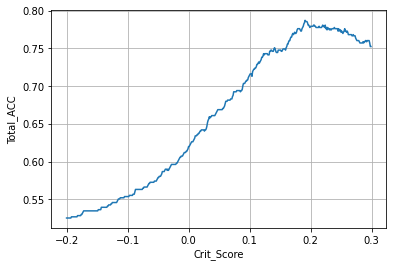

In [ ]:
acc_std=[]
for x in np.arange(-0.2,0.3,0.001):
    result_a_std=[]
    for a in std_data['total_polar_std']:    
        if a > x:
            result_a_std.append(1)
        else:
            result_a_std.append(-1)
    ac = np.sum(np.equal(std_data['S'],result_a_std))/len(result_a_std)
    acc_std.append(ac)

x= np.arange(-0.2,0.3,0.001)
y=acc_std
plt.plot(x,y)
plt.xlabel('Crit_Score')
plt.ylabel('Total_ACC')
plt.grid()
plt.show()

In [ ]:
std_pos=std_data[std_data['S']==1]
len(std_pos)

318

In [ ]:
ksaa = KSAA()
title_pol_std=[]
for i in range(318):
    for k in std_pos['Title'][i].replace('...','').replace('..','').replace('.','').split(sep='.'):
        tokens= ksaa.tokenize(k)
        token_lst=[]  
        for a in tokens:
            one_dot=a.split('/')
            if len(one_dot[0])!=int(1):
                join_dot='/'.join(one_dot)
                token_lst.append(join_dot)
        if len(token_lst) < int(2):
            token_lst=[]
        score = ksaa.get_score(token_lst)
        title_pol_std.append(score['Polarity'])

#제목 극성 /2 = title_polr
title_polr_std=np.array(title_pol_std)*0.2
print(len(title_polr_std))

text_pol_std=[]
for i in range(318):
    polar=0
    for k in std_pos['Text'][i].split(sep='.'):
        tokens= ksaa.tokenize(k)
        token_lst=[]  
        for a in tokens:
            one_dot=a.split('/')
            if len(one_dot[0])!=int(1):
                join_dot='/'.join(one_dot)
                token_lst.append(join_dot)
        if len(token_lst) < int(2):
            token_lst=[]
        score = ksaa.get_score(token_lst)
        polar+=score['Polarity']
        sen_num=len(std_data['Text'][i].split(sep='.'))
    text_pol_std.append(polar/sen_num)


text_polr_std=np.array(text_pol_std)*0.8
total_polr_std=title_polr_std + text_polr_std
news_arr_std=np.array(std_pos['S'])
std_pos['title_polar_std']=title_polr_std
std_pos['text_polar_std']=text_polr_std
std_pos['total_polar_std']=total_polr_std

318


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
std_pos

,No,Code,Date,Journal,Title,Text,URL,Sample Y/N,In Charge,S,title_polar_co,text_polar_co,total_polar_co,title_polar_std,text_polar_std,total_polar_std
0,2290,5930,2020.12.30 07:03,매일경제,"인텔, 헤지펀드서 “삼성·TSMC에 밀린다” 지적받고도 4.9% 상승",뉴욕증시에서 주요 지수는 장중 사상 최고치 기록을 다시 세운 뒤 소폭 조정이 이뤄지...,https://finance.naver.com/item/news_read.nhn?a...,A,KS,1,0.066667,0.139552,0.206219,0.066667,0.139552,0.206219
1,2812,5930,2021.02.09 15:17,파이낸셜뉴스,"삼성 vs LG, 美시장 놓고 '주방가전' 격돌",북미 최대 주방·욕실 온라인 전시회 KBIS 2021 참가 삼성전자가 'KBIS 2...,https://finance.naver.com/item/news_read.nhn?a...,Y,JH,1,0.000000,0.356104,0.356104,0.000000,0.356104,0.356104
2,6445,66570,2020.12.09 17:48,이데일리,日TV시장서 존재감 뽐내는 LG전자..중소형 신제품 줄줄이 출시,이달 중 32인치 소형 풀HD LCD TV 시리즈 출시내달 8K LCD TV 중 가...,https://finance.naver.com/item/news_read.nhn?a...,Y,JY,1,0.200000,0.355606,0.555606,0.200000,0.355606,0.555606
3,6968,66570,2020.11.03 10:00,매일경제,"LG전자, 英 프리미엄 패션 온라인 쇼핑몰에 친환경 의류가전 출시",[사진제공 = LG전자]LG전자가 영국 프리미엄 패션 온라인 쇼핑몰 네타포르테(NE...,https://finance.naver.com/item/news_read.nhn?a...,Y,SJ,1,0.000000,0.246708,0.246708,0.000000,0.246708,0.246708
4,117,5930,2021.04.12 15:40,한국경제,[단독] 삼성 '히든카드'…10만원대 초저가 갤럭시M 나오나,삼성 갤럭시M12/사진제공=삼성전자 인도법인삼성전자가 인도 시장에 주로 출시했던 초...,https://finance.naver.com/item/news_read.nhn?a...,A,JY,1,0.200000,0.428414,0.628414,0.200000,0.428414,0.628414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,765,5930,2021.03.23 15:39,이데일리,"엑시콘, 삼성전자 중국 법인에 40억원 규모 검사장비 공급",[이데일리 고준혁 기자] 엑시콘(092870)은 삼성전자 중국 법인(SCS)와 40...,https://finance.naver.com/item/news_read.nhn?a...,A,JY,1,0.000000,0.115555,0.115555,0.000000,0.115555,0.115555
314,6141,66570,2021.02.05 07:18,한국경제,"LG전자, 세탁기 공들이더니 일냈다…美 소비자 마음 싹쓸이",LG전자 창원공장의 세탁기 생산라인. 한경DBLG전자가 만든 대용량 세탁기가 미국 ...,https://finance.naver.com/item/news_read.nhn?a...,Y,JH,1,0.000000,0.466667,0.466667,0.000000,0.466667,0.466667
315,2380,5930,2021.02.25 17:18,머니투데이,좁쌀만한 이 칩으로…삼성도 더 얇은 TV 만든다,"[머니투데이 심재현 기자] 삼성전자 시스템LSI사업부 김경택, 김형태, 강상구, ...",https://finance.naver.com/item/news_read.nhn?a...,Y,SJ,1,0.000000,0.463974,0.463974,0.000000,0.463974,0.463974
316,598,5930,2021.03.30 10:08,서울경제,"삼성전자 Neo QLED 8K, TV 제품 최초 Wi-Fi 6E 인증 ...",WFA 기술표준협회 인증···2.4GHz·5GHz에 6GHz 대역 추가 사용빠르고 ...,https://finance.naver.com/item/news_read.nhn?a...,A,JY,1,0.200000,0.308327,0.508327,0.200000,0.308327,0.508327


In [ ]:
def polar_mean_std( news_copy,test_col ,target_col):
    aa=news_copy[news_copy[f'{test_col}']==-1][f'{target_col}']
    aaa=0
    # bb=news_set[news_set['Sentiment']==0][f'{polar_set}']
    # bbb=0
    cc=news_copy[news_copy[f'{test_col}']==1][f'{target_col}']
    ccc=0
    for a in aa:
        aaa+=a

    # for b in bb:
    #     bbb+=b

    for c in cc:
        ccc+=c
    print( aaa/sum(news_copy[f'{test_col}']==-1),ccc/sum(news_copy[f'{test_col}']==1))
    print(sum(news_copy[f'{test_col}']==-1),sum(news_copy[f'{test_col}']==1))

In [ ]:
polar_mean_std(std_pos,'S','title_polar_std')
polar_mean_std(std_pos,'S','text_polar_std')
polar_mean_std(std_pos,'S','total_polar_std')

0.06796643005102486
318
0.2979780494495817
318
0.36594447950060655
318


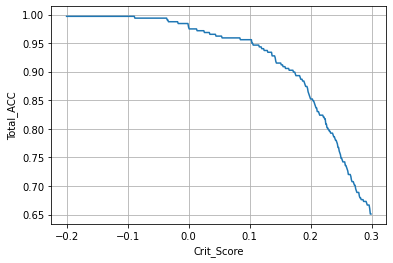

In [ ]:
acc_std_pos=[]
for x in np.arange(-0.2,0.3,0.001):
    result_a_std=[]
    for a in std_pos['total_polar_std']:    
        if a > x:
            result_a_std.append(1)
        else:
            result_a_std.append(-1)
    ac = np.sum(np.equal(std_pos['S'],result_a_std))/len(result_a_std)
    acc_std_pos.append(ac)

x= np.arange(-0.2,0.3,0.001)
y=acc_std_pos
plt.plot(x,y)
plt.xlabel('Crit_Score')
plt.ylabel('Total_ACC')
plt.grid()
plt.show()

In [ ]:
std_neg=std_data[std_data['S']==-1]
len(std_neg)

316

In [ ]:
ksaa = KSAA()
title_pol_std=[]
for i in range(316):
    for k in std_neg['Title'][i].replace('...','').replace('..','').replace('.','').split(sep='.'):
        tokens= ksaa.tokenize(k)
        token_lst=[]  
        for a in tokens:
            one_dot=a.split('/')
            if len(one_dot[0])!=int(1):
                join_dot='/'.join(one_dot)
                token_lst.append(join_dot)
        if len(token_lst) < int(2):
            token_lst=[]
        score = ksaa.get_score(token_lst)
        title_pol_std.append(score['Polarity'])

#제목 극성 /2 = title_polr
title_polr_std=np.array(title_pol_std)*0.2
print(len(title_polr_std))

text_pol_std=[]
for i in range(318):
    polar=0
    for k in std_neg['Text'][i].split(sep='.'):
        tokens= ksaa.tokenize(k)
        token_lst=[]  
        for a in tokens:
            one_dot=a.split('/')
            if len(one_dot[0])!=int(1):
                join_dot='/'.join(one_dot)
                token_lst.append(join_dot)
        if len(token_lst) < int(2):
            token_lst=[]
        score = ksaa.get_score(token_lst)
        polar+=score['Polarity']
        sen_num=len(std_data['Text'][i].split(sep='.'))
    text_pol_std.append(polar/sen_num)


text_polr_std=np.array(text_pol_std)*0.8
total_polr_std=title_polr_std + text_polr_std
news_arr_std=np.array(std_neg['S'])
std_neg['title_polar_std']=title_polr_std
std_neg['text_polar_std']=text_polr_std
std_neg['total_polar_std']=total_polr_std

KeyError: ignored

In [ ]:
polar_mean_std(std_pos,'S','title_polar_std')
polar_mean_std(std_pos,'S','text_polar_std')
polar_mean_std(std_pos,'S','total_polar_std')

# **neut->neg resize_data**

In [ ]:
news_resize = pd.read_excel('/content/C01-1_KM_Data_LabelingResult_incl_resize.xlsx')
news_neg= news_resize[news_resize['S']==-1]
news_neut= news_resize[news_resize['S']==0]
news_pos=news_resize[news_resize['S']==1]

news_neut['S']=-1

from sklearn.model_selection import train_test_split

P_train, P_test = train_test_split(news_pos, test_size=0.379, random_state=123)
st_data=pd.concat([P_test, news_neg], ignore_index=True)
std_data_re=pd.concat([st_data, news_neut], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
std_data_re[702:704]

,No,Code,Date,Journal,Title,Text,URL,Sample Y/N,In Charge,S
702,135,5930,2021.04.11 17:06,한국경제,"""삼성전자 투자 망할 일 없다고? '올인'하면 큰코다친다""","반도체 패권전쟁 승자는…""美·日 분산투자하라"" 삼성전자 '올인'…위험한 까닭은美·日...",https://finance.naver.com/item/news_read.nhn?a...,Y,JH,-1
703,137,5930,2021.04.11 11:49,한국경제,지난해 삼성전자 빼고 투자 감소…올해도 韓 투자 '빨간불',사진=게티이미지뱅크주요 기업 100개사 중 절반 이상이 올해 투자 계획이 없거나 투...,https://finance.naver.com/item/news_read.nhn?a...,Y,JH,-1


In [ ]:
ksaa = KSAA()
title_pol_std_re=[]
for i in range(1384):
    for k in std_data_re['Title'][i].replace('...','').replace('..','').replace('.','').split(sep='.'):
        tokens= ksaa.tokenize(k)
        token_lst=[]  
        for a in tokens:
            one_dot=a.split('/')
            if len(one_dot[0])!=int(1):
                join_dot='/'.join(one_dot)
                token_lst.append(join_dot)
        if len(token_lst) < int(2):
            token_lst=[]
        score = ksaa.get_score(token_lst)
        title_pol_std_re.append(score['Polarity'])

#제목 극성 /2 = title_polr
title_polr_std_re=np.array(title_pol_std_re)*0.2
print(len(title_polr_std_re))

text_pol_std_re=[]
for i in range(1384):
    polar=0
    for k in std_data_re['Text'][i].split(sep='.'):
        try:
            tokens= ksaa.tokenize(k)
            token_lst=[]  
            for a in tokens:
                one_dot=a.split('/')
                if len(one_dot[0])!=int(1):
                    join_dot='/'.join(one_dot)
                    token_lst.append(join_dot)
            if len(token_lst) < int(2):
                token_lst=[]
            score = ksaa.get_score(token_lst)
            polar+=score['Polarity']
            sen_num=len(std_data_re['Text'][i].split(sep='.'))
        except:
            pass
    text_pol_std_re.append(polar/sen_num)


text_polr_std_re=np.array(text_pol_std_re)*0.8
total_polr_std_re=title_polr_std_re + text_polr_std_re
news_arr_std=np.array(std_data_re['S'])
std_data_re['title_polar_std']=title_polr_std_re
std_data_re['text_polar_std']=text_polr_std_re
std_data_re['total_polar_std']=total_polr_std_re

1384


In [ ]:
polar_mean_std(std_data_re,'S','title_polar_std')
polar_mean_std(std_data_re,'S','text_polar_std')
polar_mean_std(std_data_re,'S','total_polar_std')

0.018607892718090643 0.06806630951335829
692 692
0.19008006950166667 0.2845218293729731
692 692
0.20868796221975736 0.3525881388863312
692 692


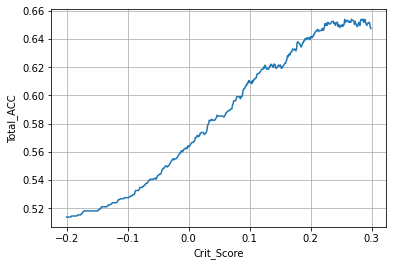

In [ ]:
acc_std=[]
for x in np.arange(-0.2,0.3,0.001):
    result_a_std=[]
    for a in std_data_re['total_polar_std']:    
        if a > x:
            result_a_std.append(1)
        else:
            result_a_std.append(-1)
    ac = np.sum(np.equal(std_data_re['S'],result_a_std))/len(result_a_std)
    acc_std.append(ac)

x= np.arange(-0.2,0.3,0.001)
y=acc_std
plt.plot(x,y)
plt.xlabel('Crit_Score')
plt.ylabel('Total_ACC')
plt.grid()
plt.show()